# AutoGluon Tabular with SageMaker

[AutoGluon](https://github.com/awslabs/autogluon) automates machine learning tasks enabling you to easily achieve strong predictive performance in your applications. With just a few lines of code, you can train and deploy high-accuracy deep learning models on tabular, image, and text data.
This notebook shows how to use AutoGluon-Tabular with Amazon SageMaker by creating custom containers.

## Prerequisites

If using a SageMaker hosted notebook, select kernel `conda_mxnet_p36`.

In [1]:
# Make sure docker compose is set up properly for local mode
!./setup.sh

The user has root access.
SageMaker instance route table setup is ok. We are good to go.
SageMaker instance routing for Docker is ok. We are good to go!


In [2]:
import os
import sys
import boto3
import sagemaker
from time import sleep
from collections import Counter
import numpy as np
import pandas as pd
from sagemaker import get_execution_role, local, Model, utils, s3
from sagemaker.estimator import Estimator
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import StringDeserializer
from sklearn.metrics import accuracy_score, classification_report
from IPython.core.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell

# Print settings
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 10)

# Account/s3 setup
session = sagemaker.Session()
local_session = local.LocalSession()
bucket = session.default_bucket()
prefix = 'sagemaker/autogluon-tabular'
region = session.boto_region_name
role = get_execution_role()
client = session.boto_session.client(
    "sts", region_name=region, endpoint_url=utils.sts_regional_endpoint(region)
    )
account = client.get_caller_identity()['Account']

registry_uri_training = sagemaker.image_uris.retrieve('mxnet', region, version= '1.7.0', py_version='py3', instance_type='ml.m5.2xlarge', image_scope='training')
registry_uri_inference = sagemaker.image_uris.retrieve('mxnet', region, version= '1.7.0', py_version='py3', instance_type='ml.m5.2xlarge', image_scope='inference')
ecr_uri_prefix = account +'.'+'.'.join(registry_uri_training.split('/')[0].split('.')[1:])

### (Optional) Move docker to the SageMaker volume

The size of AutoGluon image will exceed 6GB. This may take up the volume that docker daemon uses. In order to avoid this issue, you can move docker to a location which has additional storage space.

First, you need to stop docker.

In [3]:
!sudo service docker stop

Stopping docker: [  OK  ]


Let's make sure it is stopped, by checking what is running.

In [4]:
!ps aux | grep -i docker | grep -v grep

Now you will create a docker storage location that has more storage, typically you can look at `df -h` to find a location with more storage; however, this generally will be your SageMaker/some_dir location. You can modify /home/ec2-user/SageMaker/docker to a new location.

In [5]:
!mkdir -p /home/ec2-user/SageMaker/docker

Next, modify the daemon.json file to add a data-root location which points to your new location. 

In [6]:
!cp "/etc/docker/daemon.json" .

In [7]:
!cat daemon.json

{
    "runtimes": {
        "nvidia": {
            "path": "nvidia-container-runtime",
            "runtimeArgs": []
        }
    }
}


In [8]:
import json 
with open('daemon.json','r') as f:
    file_output = json.loads(f.read())
with open('daemon.json','w') as f:
    file_output['data-root'] = '/home/ec2-user/SageMaker/docker'
    f.write(json.dumps(file_output))
!cat daemon.json

129

{"runtimes": {"nvidia": {"path": "nvidia-container-runtime", "runtimeArgs": []}}, "data-root": "/home/ec2-user/SageMaker/docker"}

Now that you have appropriately modified your daemon.json file you need to move it and rsync it.

In [9]:
!sudo mv daemon.json "/etc/docker/"

In [10]:
!sudo rsync -aqxP /var/lib/docker/ /home/ec2-user/SageMaker/docker

Finally, you need to get rid of your previous docker and start the service.

In [11]:
!sudo mv /var/lib/docker /var/lib/docker.old

In [12]:
!sudo service docker start

Starting docker:	.[  OK  ]


You can confirm you did everything correctly with `df -h`.

In [13]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
devtmpfs        2.0G   64K  2.0G   1% /dev
tmpfs           2.0G     0  2.0G   0% /dev/shm
/dev/xvda1       94G   83G   11G  89% /
/dev/xvdf       492G  620M  466G   1% /home/ec2-user/SageMaker


In [14]:
!cat /etc/docker/daemon.json

{"runtimes": {"nvidia": {"path": "nvidia-container-runtime", "runtimeArgs": []}}, "data-root": "/home/ec2-user/SageMaker/docker"}

Make sure the service is running.

In [15]:
!ps aux | grep -i docker | grep -v grep

root      7076  0.8  2.2 497904 90536 ?        Sl   18:55   0:00 /usr/bin/dockerd --default-ulimit nofile=1024:4096
root      7086  0.6  1.3 437816 53260 ?        Ssl  18:55   0:00 containerd --config /var/run/docker/containerd/containerd.toml --log-level info


### Build docker images

Build the training/inference image and push to ECR

In [16]:
training_algorithm_name = 'autogluon-sagemaker-training'
inference_algorithm_name = 'autogluon-sagemaker-inference'

In [17]:
!/bin/bash ./container-training/build_push_training.sh {account} {region} {training_algorithm_name} {ecr_uri_prefix} {registry_uri_training.split('/')[0].split('.')[0]} {registry_uri_training}
!/bin/bash ./container-inference/build_push_inference.sh {account} {region} {inference_algorithm_name} {ecr_uri_prefix} {registry_uri_training.split('/')[0].split('.')[0]} {registry_uri_inference}

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Sending build context to Docker daemon  14.33MB
Step 1/15 : ARG REGISTRY_URI
Step 2/15 : FROM ${REGISTRY_URI}
1.7.0-cpu-py3: Pulling from mxnet-training

a89234b4: Pulling fs layer 
26c6b9c9: Pulling fs layer 
bf18aa40: Pulling fs layer 
c688ebe3: Pulling fs layer 
528d0665: Pulling fs layer 
14a3ecbd: Pulling fs layer 
2bb40393: Pulling fs layer 
9019f8fc: Pulling fs

### Get the data

In this example we'll use the direct-marketing dataset to build a binary classification model that predicts whether customers will accept or decline a marketing offer.  
First we'll download the data and split it into train and test sets. AutoGluon does not require a separate validation set (it uses bagged k-fold cross-validation).

In [19]:
# Download and unzip the data
!aws s3 cp --region {region} s3://sagemaker-sample-data-{region}/autopilot/direct_marketing/bank-additional.zip .
!unzip -qq -o bank-additional.zip
!rm bank-additional.zip

local_data_path = './bank-additional/bank-additional-full.csv'
data = pd.read_csv(local_data_path)

# Split train/test data
train = data.sample(frac=0.7, random_state=42)
test = data.drop(train.index)

# Split test X/y
label = 'y'
y_test = test[label]
X_test = test.drop(columns=[label])

download: s3://sagemaker-sample-data-us-east-1/autopilot/direct_marketing/bank-additional.zip to ./bank-additional.zip


##### Check the data

In [20]:
train.head(3)
train.shape

test.head(3)
test.shape

X_test.head(3)
X_test.shape

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
32884,57,technician,married,high.school,no,no,yes,cellular,may,mon,371,1,999,1,failure,-1.8,92.893,-46.2,1.299,5099.1,no
3169,55,unknown,married,unknown,unknown,yes,no,telephone,may,thu,285,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
32206,33,blue-collar,married,basic.9y,no,no,no,cellular,may,fri,52,1,999,1,failure,-1.8,92.893,-46.2,1.313,5099.1,no


(28832, 21)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,50,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
10,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,55,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


(12356, 21)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
9,25,services,single,high.school,no,yes,no,telephone,may,mon,50,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
10,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,55,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


(12356, 20)

Upload the data to s3

In [21]:
train_file = 'train.csv'
train.to_csv(train_file,index=False)
train_s3_path = session.upload_data(train_file, key_prefix='{}/data'.format(prefix))

test_file = 'test.csv'
test.to_csv(test_file,index=False)
test_s3_path = session.upload_data(test_file, key_prefix='{}/data'.format(prefix))

X_test_file = 'X_test.csv'
X_test.to_csv(X_test_file,index=False)
X_test_s3_path = session.upload_data(X_test_file, key_prefix='{}/data'.format(prefix))

## Hyperparameter Selection

The minimum required settings for training is just a target label, `init_args['label']`.

Additional optional hyperparameters can be passed to the `autogluon.tabular.TabularPredictor.fit` function via `fit_args`.

Below shows a more in depth example of AutoGluon-Tabular hyperparameters from the example [Predicting Columns in a Table - In Depth](https://auto.gluon.ai/stable/tutorials/tabular_prediction/tabular-indepth.html). Please see [fit parameters](https://auto.gluon.ai/stable/_modules/autogluon/tabular/predictor/predictor.html#TabularPredictor) for further information. Note that in order for hyperparameter ranges to work in SageMaker, values passed to the `fit_args['hyperparameters']` must be represented as strings.

```python
nn_options = {
    'num_epochs': "10",
    'learning_rate': "ag.space.Real(1e-4, 1e-2, default=5e-4, log=True)",
    'activation': "ag.space.Categorical('relu', 'softrelu', 'tanh')",
    'layers': "ag.space.Categorical([100],[1000],[200,100],[300,200,100])",
    'dropout_prob': "ag.space.Real(0.0, 0.5, default=0.1)"
}

gbm_options = {
    'num_boost_round': "100",
    'num_leaves': "ag.space.Int(lower=26, upper=66, default=36)"
}

model_hps = {'NN': nn_options, 'GBM': gbm_options} 

init_args = {
  'eval_metric' : 'roc_auc'  
  'label': 'y'
}

fit_args = {
  'presets': ['best_quality', 'optimize_for_deployment'],
  'time_limits': 60*10,
  'hyperparameters': model_hps,
  'hyperparameter_tune': True,
  'search_strategy': 'skopt'
}


hyperparameters = {
  'fit_args': fit_args,
  'feature_importance': True
}
```
**Note:** Your hyperparameter choices may affect the size of the model package, which could result in additional time taken to upload your model and complete training. Including `'optimize_for_deployment'` in the list of `fit_args['presets']` is recommended to greatly reduce upload times.

<br>

In [22]:
# Define required label and optional additional parameters
init_args = {
  'label': 'y'
}

# Define additional parameters
fit_args = {
  # Adding 'best_quality' to presets list will result in better performance (but longer runtime)
  'presets': ['optimize_for_deployment'],
}

# Pass fit_args to SageMaker estimator hyperparameters
hyperparameters = {
  'init_args': init_args,   
  'fit_args': fit_args,
  'feature_importance': True
}

tags = [{
    'Key' : 'AlgorithmName',
    'Value' : 'AutoGluon-Tabular'
}]

## Train

For local training set `train_instance_type` to `local` .   
For non-local training the recommended instance type is `ml.m5.2xlarge`.   

**Note:** Depending on how many underlying models are trained, `train_volume_size` may need to be increased so that they all fit on disk.

In [23]:
%%time

instance_type = 'ml.m5.2xlarge'
#instance_type = 'local'

ecr_image = f'{ecr_uri_prefix}/{training_algorithm_name}:latest'

estimator = Estimator(image_uri=ecr_image,
                      role=role,
                      instance_count=1,
                      instance_type=instance_type,
                      hyperparameters=hyperparameters,
                      volume_size=100,
                      tags=tags)

# Set inputs. Test data is optional, but requires a label column.
inputs = {'training': train_s3_path, 'testing': test_s3_path}

estimator.fit(inputs)

2021-04-01 19:42:26 Starting - Starting the training job...ProfilerReport-1617306145: InProgress
..................
2021-04-01 19:45:29 Starting - Launching requested ML instances.........
2021-04-01 19:47:23 Starting - Preparing the instances for training...
2021-04-01 19:47:58 Downloading - Downloading input data
2021-04-01 19:47:58 Training - Downloading the training image.................2021-04-01 19:50:42,798 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2021-04-01 19:50:42,800 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-04-01 19:50:42,801 sagemaker-training-toolkit INFO     Failed to parse hyperparameter init_args value {'label': 'y'} to Json.
Returning the value itself
2021-04-01 19:50:42,801 sagemaker-training-toolkit INFO     Failed to parse hyperparameter fit_args value {'presets': ['optimize_for_deployment']} to Json.
Returning the value itself
2021-04-01 19:50:42,801 sagemaker-training-

### Review the performance of the trained model

In [25]:
from utils.ag_utils import launch_viewer

launch_viewer(is_debug=False)

HTML(value='\n        <style>\n            .output_scroll {\n                height: unset !important;\n      …

HTML(value="<b><font size=4 color='#000099'>AutoGluon Model Performance Viewer</font></b>")

interactive(children=(Dropdown(description='Job_Name', options=('-- Select job --', 'autogluon-sagemaker-train…

### Create Model

In [26]:
# Create predictor object
class AutoGluonTabularPredictor(Predictor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, 
                         serializer=CSVSerializer(), 
                         deserializer=StringDeserializer(), **kwargs)

In [27]:
ecr_image = f'{ecr_uri_prefix}/{inference_algorithm_name}:latest'

if instance_type == 'local':
    model = estimator.create_model(image_uri=ecr_image, role=role)
else:
    #model_uri = os.path.join(estimator.output_path, estimator._current_job_name, "output", "model.tar.gz")
    model_uri = estimator.model_data
    model = Model(ecr_image, model_data=model_uri, role=role, sagemaker_session=session, predictor_cls=AutoGluonTabularPredictor)

### Batch Transform

For local mode, either `s3://<bucket>/<prefix>/output/` or `file:///<absolute_local_path>` can be used as outputs.

By including the label column in the test data, you can also evaluate prediction performance (In this case, passing `test_s3_path` instead of `X_test_s3_path`).

In [28]:
output_path = f's3://{bucket}/{prefix}/output/'
# output_path = f'file://{os.getcwd()}'

transformer = model.transformer(instance_count=1, 
                                instance_type=instance_type,
                                strategy='MultiRecord',
                                max_payload=6,
                                max_concurrent_transforms=1,                              
                                output_path=output_path)

transformer.transform(test_s3_path, content_type='text/csv', split_type='Line')
transformer.wait()

2021-04-01 20:14:10,291 [INFO ] main com.amazonaws.ml.mms.ModelServer - 
MMS Home: /usr/local/lib/python3.6/site-packages
Current directory: /
Temp directory: /home/model-server/tmp
Number of GPUs: 0
Number of CPUs: 8
Max heap size: 6212 M
2021-04-01 20:14:10,291 [INFO ] main com.amazonaws.ml.mms.ModelServer - 
MMS Home: /usr/local/lib/python3.6/site-packages
Current directory: /
Temp directory: /home/model-server/tmp
Number of GPUs: 0
Number of CPUs: 8
Max heap size: 6212 M
Python executable: /usr/local/bin/python3.6
Config file: /etc/sagemaker-mms.properties
Inference address: http://0.0.0.0:8080
Management address: http://0.0.0.0:8080
Model Store: /.sagemaker/mms/models
Initial Models: ALL
Log dir: /logs
Metrics dir: /logs
Netty threads: 0
Netty client threads: 0
Default workers per model: 8
Blacklist Regex: N/A
Maximum Response Size: 6553500
Maximum Request Size: 6553500
Preload model: false
Prefer direct buffer: false
2021-04-01 20:14:10,369 [WARN ] W-9000-model com.amazonaws.ml.m

### Endpoint

##### Deploy remote or local endpoint

In [29]:
instance_type = 'ml.m5.2xlarge'
#instance_type = 'local'

predictor = model.deploy(initial_instance_count=1, 
                         instance_type=instance_type)

---------------!

##### Attach to endpoint (or reattach if kernel was restarted)

In [30]:
# Select standard or local session based on instance_type
if instance_type == 'local': 
    sess = local_session
else: 
    sess = session

# Attach to endpoint
predictor = AutoGluonTabularPredictor(predictor.endpoint, sagemaker_session=sess)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


##### Predict on unlabeled test data

In [31]:
results = predictor.predict(X_test.to_csv(index=False)).splitlines()

# Check output
threshold = 0.5
y_results = np.array(['yes' if float(i.split(",")[1]) > threshold else 'no' for i in results])

print(Counter(y_results))

Counter({'no': 11301, 'yes': 1055})


##### Predict on data that includes label column  
Prediction performance metrics will be printed to endpoint logs.

In [32]:
results = predictor.predict(test.to_csv(index=False)).splitlines()

# Check output
threshold = 0.5
y_results = np.array(['yes' if float(i.split(",")[1]) > threshold else 'no' for i in results])

print(Counter(y_results))

Counter({'no': 11301, 'yes': 1055})


##### Check that classification performance metrics match evaluation printed to endpoint logs as expected

In [33]:
threshold = 0.5
y_results = np.array(['yes' if float(i.split(",")[1]) > threshold else 'no' for i in results])

print("accuracy: {}".format(accuracy_score(y_true=y_test, y_pred=y_results)))
print(classification_report(y_true=y_test, y_pred=y_results, digits=6))

accuracy: 0.9201197798640337
              precision    recall  f1-score   support

          no   0.941244  0.970529  0.955662     10960
         yes   0.693839  0.524355  0.597307      1396

    accuracy                       0.920120     12356
   macro avg   0.817542  0.747442  0.776485     12356
weighted avg   0.913292  0.920120  0.915175     12356



##### Clean up endpoint

In [34]:
predictor.delete_endpoint()

## Explainability with Amazon SageMaker Clarify

There are expanding business needs and legislative regulations that require explainations of why a model mades the decision it did. SHAP (SHapley Additive exPlanations) is an approach to explain the output of machine learning models. SHAP values represent a feature's contribution to a change in the model output. SageMaker Clarify uses SHAP to explain the contribution that each input feature makes to the final decision.

##### Set parameters for SHAP calculation

In [35]:
seed = 0
num_rows = 500

#Write a csv file used by SageMaker Clarify
test_explainavility_file = 'test_explainavility.csv'
train.head(num_rows).to_csv(test_explainavility_file, index=False, header=False)
test_explainavility_s3_path = session.upload_data(test_explainavility_file, key_prefix='{}/data'.format(prefix))

##### Specify computing resources

In [36]:
from sagemaker import clarify

model_name = estimator.latest_training_job.job_name
container_def = model.prepare_container_def()
session.create_model(model_name,
                     role,
                     container_def)

clarify_processor = clarify.SageMakerClarifyProcessor(role=role,
                                                      instance_count=1,
                                                      instance_type='ml.c4.xlarge',
                                                      sagemaker_session=session)
model_config = clarify.ModelConfig(model_name=model_name,
                                   instance_type='ml.c5.xlarge',
                                   instance_count=1,
                                   accept_type='text/csv')

'autogluon-sagemaker-training-2021-04-01-19-42-25-645'

##### Run a SageMaker Clarify job

In [37]:
shap_config = clarify.SHAPConfig(baseline=X_test.sample(15, random_state=seed).values.tolist(),
                                 num_samples=100,
                                 agg_method='mean_abs')

explainability_output_path = 's3://{}/{}/{}/clarify-explainability'.format(bucket, prefix, model_name)
explainability_data_config = clarify.DataConfig(s3_data_input_path=test_explainavility_s3_path,
                                s3_output_path=explainability_output_path,
                                label='y',
                                headers=train.columns.to_list(),
                                dataset_type='text/csv')

predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.5)

clarify_processor.run_explainability(data_config=explainability_data_config,
                                     model_config=model_config,
                                     explainability_config=shap_config)


Job Name:  Clarify-Explainability-2021-04-01-20-31-14-470
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-332270294944/sagemaker/autogluon-tabular/data/test_explainavility.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-332270294944/sagemaker/autogluon-tabular/autogluon-sagemaker-training-2021-04-01-19-42-25-645/clarify-explainability/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-332270294944/sagemaker/autogluon-tabular/autogluon-sagemaker-traini

##### View the Explainability Report

You can view the explainability report in Studio under the experiments tab. If you're not a Studio user yet, as with the Bias Report, you can access this report at the following S3 bucket.

In [38]:
!aws s3 cp {explainability_output_path} . --recursive

download: s3://sagemaker-us-east-1-332270294944/sagemaker/autogluon-tabular/autogluon-sagemaker-training-2021-04-01-19-42-25-645/clarify-explainability/analysis_config.json to ./analysis_config.json
download: s3://sagemaker-us-east-1-332270294944/sagemaker/autogluon-tabular/autogluon-sagemaker-training-2021-04-01-19-42-25-645/clarify-explainability/analysis.json to ./analysis.json
download: s3://sagemaker-us-east-1-332270294944/sagemaker/autogluon-tabular/autogluon-sagemaker-training-2021-04-01-19-42-25-645/clarify-explainability/explanations_shap/baseline.csv to explanations_shap/baseline.csv
download: s3://sagemaker-us-east-1-332270294944/sagemaker/autogluon-tabular/autogluon-sagemaker-training-2021-04-01-19-42-25-645/clarify-explainability/report.pdf to ./report.pdf
download: s3://sagemaker-us-east-1-332270294944/sagemaker/autogluon-tabular/autogluon-sagemaker-training-2021-04-01-19-42-25-645/clarify-explainability/report.ipynb to ./report.ipynb
download: s3://sagemaker-us-east-1-33

Global explanatory methods allow understanding the model and its feature contributions in aggregate over multiple datapoints. Here we show an aggregate bar plot that plots the mean absolute SHAP value for each feature.

In [39]:
!{sys.executable} -m pip install shap

     |████████████████████████████████| 356 kB 17.0 MB/s eta 0:00:01
     |████████████████████████████████| 74 kB 505 kB/s  eta 0:00:01
  Created wheel for shap: filename=shap-0.39.0-cp36-cp36m-linux_x86_64.whl size=419931 sha256=ba3701fc42de67a27cf75db2411cf5842c0c8f2a4b0cc68a5edabd423421e2b2
  Stored in directory: /home/ec2-user/.cache/pip/wheels/6f/08/25/2992725334291786ea084e06cac493d93049b80e3470318a1b
Successfully built shap


In [40]:
shap_values_test = pd.read_csv('explanations_shap/out.csv')
shap_values_test.abs().mean().to_dict()

{'age_label0': 0.006630587176137189,
 'job_label0': 0.006630586965618387,
 'marital_label0': 0.006648149137004843,
 'education_label0': 0.00664814863903077,
 'default_label0': 0.0059577371634002875,
 'housing_label0': 0.00595773689228564,
 'loan_label0': 0.0057980830725800495,
 'contact_label0': 0.00579808259436115,
 'month_label0': 0.006065404902412887,
 'day_of_week_label0': 0.006065404677977921,
 'duration_label0': 0.006071790337167681,
 'campaign_label0': 0.006071789845556502,
 'pdays_label0': 0.006446740375994957,
 'previous_label0': 0.006446739909773549,
 'poutcome_label0': 0.006335252391814035,
 'emp.var.rate_label0': 0.0063352521317917776,
 'cons.price.idx_label0': 0.014493621801941341,
 'cons.conf.idx_label0': 0.014493621593483103,
 'euribor3m_label0': 0.0068436770921508645,
 'nr.employed_label0': 0.006843676599993037,
 'age_label1': 0.08871479070774428,
 'job_label1': 0.08871479079832177,
 'marital_label1': 0.006197671961943794,
 'education_label1': 0.006197671583763206,
 'de

-------------------------------

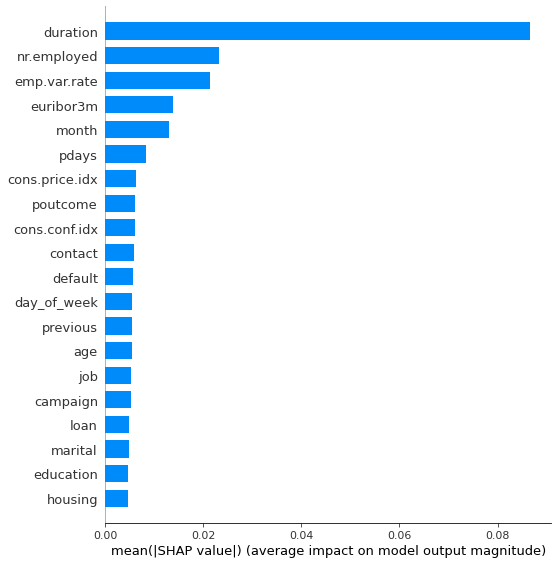

In [148]:
import shap
#shap_values = pd.read_csv('explanations_shap/out.csv')
shap_values = pd.read_csv('out2.csv')
#shap_values = shap_values_[shap_values_.columns[-20:]]
shap.summary_plot(shap_values.to_numpy(), plot_type='bar', feature_names=train.columns.tolist())

In [149]:
shap_values

,age_label0,job_label0,marital_label0,education_label0,default_label0,housing_label0,loan_label0,contact_label0,month_label0,day_of_week_label0,duration_label0,campaign_label0,pdays_label0,previous_label0,poutcome_label0,emp.var.rate_label0,cons.price.idx_label0,cons.conf.idx_label0,euribor3m_label0,nr.employed_label0
0,0.004712,-0.013592,0.003095,-0.002744,0.004623,-0.000900,0.004908,0.006570,-0.026616,-0.008116,0.020967,0.006364,-0.007908,-0.011312,0.012764,0.035602,-0.002052,0.001494,-0.007748,0.012712
1,0.002023,-0.002656,-0.000262,-0.000672,-0.006130,0.001432,0.007231,-0.003672,-0.010008,0.003383,-0.014454,-0.007138,0.004781,-0.002418,0.001048,-0.010910,0.000738,-0.003179,0.001675,0.001853
2,0.003141,-0.005342,-0.006248,-0.001315,0.000766,0.002172,0.010707,-0.002202,-0.003662,-0.000555,-0.057507,0.003239,-0.001461,0.003882,0.006587,0.016791,-0.007907,-0.003943,-0.000312,-0.001400
3,0.000180,-0.002539,-0.008264,0.001268,-0.006748,-0.002397,0.000300,-0.005734,0.004208,0.001941,-0.011588,0.005006,0.003251,0.000392,-0.000100,-0.007257,0.007188,-0.001742,-0.002772,-0.002408
4,-0.002083,0.000213,0.000980,0.001434,-0.000498,0.000973,0.003638,0.001946,0.001111,0.000692,-0.040605,0.000787,-0.000221,0.002001,-0.000563,-0.006459,0.000769,-0.004331,-0.000272,-0.002606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.000746,0.000764,0.000274,0.000044,-0.000569,0.001535,0.001656,-0.000436,0.001387,0.001290,-0.048429,0.001362,-0.001084,0.001801,0.001175,-0.004362,0.002713,-0.002824,0.000503,-0.002381
496,0.002823,-0.000791,-0.006362,-0.000094,0.001603,-0.000763,-0.001439,0.000463,-0.005365,0.000606,-0.029650,0.000369,-0.000656,0.000958,0.000105,-0.008383,-0.002642,0.000235,0.006163,0.002045
497,-0.000254,-0.000655,-0.002050,0.000385,0.001580,-0.001608,0.000579,-0.000575,-0.000348,0.001197,-0.046554,0.004505,0.000673,-0.001115,-0.000529,-0.004684,0.001046,0.000973,0.002421,-0.001556
498,-0.004918,0.000444,0.008646,-0.000808,0.001283,0.002244,-0.004437,-0.000007,-0.009298,-0.001767,-0.048847,-0.004981,0.005021,-0.005400,0.002169,0.026366,-0.004828,-0.004221,-0.009967,0.016273


In [154]:
shap_values_test.abs().mean().iloc[20:]

age_label1               0.088426
job_label1               0.088426
marital_label1           0.006829
education_label1         0.006829
default_label1           0.009334
                           ...   
emp.var.rate_label1      0.007785
cons.price.idx_label1    0.024248
cons.conf.idx_label1     0.024248
euribor3m_label1         0.020748
nr.employed_label1       0.020748
Length: 20, dtype: float64

In [88]:
num_features = len(train.head(num_rows).drop(['y'], axis = 1).columns)

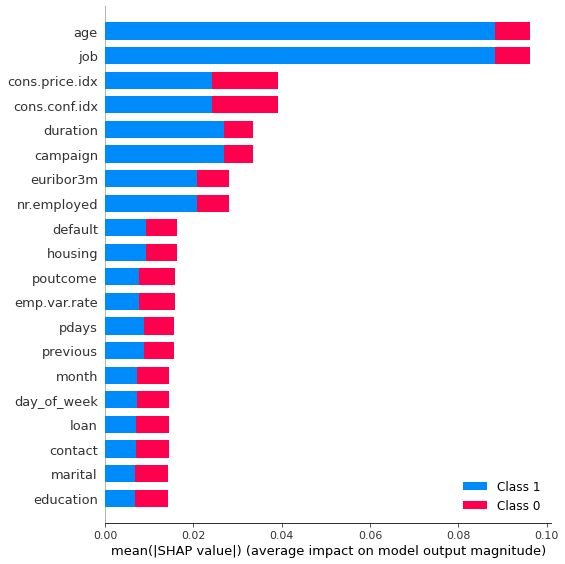

In [94]:
import shap
shap_values_ = pd.read_csv('explanations_shap/out.csv')
shap_values = [shap_values_.to_numpy()[:,:num_features], shap_values_.to_numpy()[:,num_features:]]
shap.summary_plot(shap_values, 
                  plot_type='bar', 
                  feature_names=train.head(num_rows).drop(['y'], axis = 1).columns.tolist())


The detailed summary plot below can provide more context over the above bar chart. It tells which features are most important and, in addition, their range of effects over the dataset. The color allows us to match how changes in the value of a feature effect the change in prediction. The 'red' indicates higher value of the feature and 'blue' indicates lower (normalized over the features).

In [105]:
shap.plots.beeswarm(np.array(shap_values))

UnboundLocalError: local variable 'values' referenced before assignment

In [99]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

AttributeError: 'numpy.ndarray' object has no attribute 'base_values'

In [98]:
shap_values[0]

array([[-1.71385207e-02,  1.71385269e-02, -6.81348478e-03, ...,
        -1.08657946e-02, -6.14680472e-03,  6.14680603e-03],
       [-3.46311598e-03,  3.46311613e-03, -2.99731327e-03, ...,
         1.27924040e-03,  4.30771617e-04, -4.30771653e-04],
       [ 2.01956756e-03, -2.01956573e-03,  9.71893929e-03, ...,
         1.56251972e-03, -1.78525272e-03,  1.78525430e-03],
       ...,
       [-1.30662653e-04,  1.30657624e-04, -9.07118292e-04, ...,
        -1.66471938e-03,  5.31299493e-04, -5.31288685e-04],
       [ 4.10111122e-03, -4.10110943e-03,  1.01808107e-02, ...,
        -8.76125782e-05, -1.25654916e-02,  1.25654929e-02],
       [ 4.08373450e-04, -4.08380197e-04,  2.38010020e-03, ...,
        -1.85889858e-03, -1.25582203e-03,  1.25581993e-03]])

In [135]:
shap_values_[shap_values_.columns[:20]]

,age_label0,job_label0,marital_label0,education_label0,default_label0,housing_label0,loan_label0,contact_label0,month_label0,day_of_week_label0,duration_label0,campaign_label0,pdays_label0,previous_label0,poutcome_label0,emp.var.rate_label0,cons.price.idx_label0,cons.conf.idx_label0,euribor3m_label0,nr.employed_label0
0,-0.017139,0.017139,-0.006813,0.006813,0.001366,-0.001366,0.014654,-0.014654,-0.015869,0.015869,-0.011699,0.011699,-0.006441,0.006441,0.028650,-0.028650,0.010866,-0.010866,-0.006147,0.006147
1,-0.003463,0.003463,-0.002997,0.002997,0.004533,-0.004533,0.000559,-0.000559,0.006566,-0.006566,-0.004941,0.004941,-0.000198,0.000198,-0.004982,0.004982,-0.001279,0.001279,0.000431,-0.000431
2,0.002020,-0.002020,0.009719,-0.009719,-0.004003,0.004003,0.008558,-0.008558,0.000395,-0.000395,0.001698,-0.001698,0.001658,-0.001658,-0.004496,0.004496,-0.001563,0.001563,-0.001785,0.001785
3,0.009776,-0.009776,0.010254,-0.010254,0.001800,-0.001800,0.003693,-0.003693,0.004678,-0.004678,0.005315,-0.005315,-0.003103,0.003103,0.001985,-0.001985,-0.016570,0.016570,0.000993,-0.000993
4,-0.001757,0.001757,-0.000195,0.000195,0.006844,-0.006844,0.001985,-0.001985,0.003117,-0.003117,0.001046,-0.001046,-0.006035,0.006035,0.001711,-0.001711,-0.002374,0.002374,0.002230,-0.002230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.000058,-0.000058,0.001418,-0.001418,-0.001509,0.001509,0.002420,-0.002420,-0.000395,0.000395,0.000486,-0.000486,-0.000289,0.000289,-0.003774,0.003774,-0.003125,0.003125,-0.000337,0.000337
496,-0.008096,0.008096,0.005186,-0.005186,0.000827,-0.000827,-0.001421,0.001421,-0.001695,0.001695,-0.004308,0.004308,-0.002188,0.002188,-0.002250,0.002250,0.009731,-0.009731,0.006283,-0.006283
497,-0.000131,0.000131,-0.000907,0.000907,0.001072,-0.001072,-0.001849,0.001849,-0.000900,0.000900,0.003183,-0.003183,0.000644,-0.000644,-0.001849,0.001849,0.001665,-0.001665,0.000531,-0.000531
498,0.004101,-0.004101,0.010181,-0.010181,0.009219,-0.009219,-0.011100,0.011100,0.003433,-0.003433,-0.002840,0.002840,-0.003223,0.003223,0.002760,-0.002760,0.000088,-0.000088,-0.012565,0.012565


In [ ]:
shap.summary_plot(shap_values.to_numpy(), train.head(num_rows).drop(['y'], axis = 1))

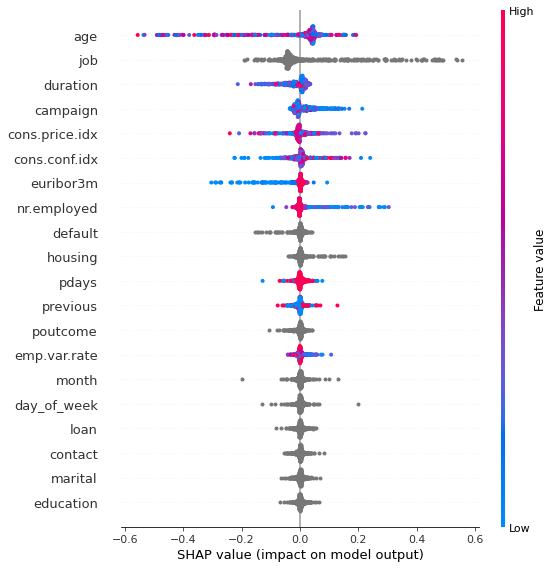

In [139]:
shap.summary_plot(shap_values_[shap_values_.columns[20:]].to_numpy(), 
                  train.head(num_rows).drop(['y'], axis = 1))